#**스마트폰 센서 데이터 기반 모션 분류**
# 단계1 : 탐색적 데이터 분석

## 0.미션

### (1) 미션①
수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.


### (2) 미션②  
다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 target을 추가하여 EDA를 수행해 봅시다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from joblib import dump

* 변수 중요도 함수 생성
    * 변수 중요도를 시각화할 수 있는 함수를 제공합니다.
    * 입력 : 
        * importance : 트리모델의 변수 중요도(예: model.feature_importances_)
        * names : 변수 이름 목록(예 : x_train.columns
        * result_only  : 변수 중요도 순으로 데이터프레임만 return할지, 그래프도 포함할지 결정. False이면 결과 데이터프레임 + 그래프
        * topn : 중요도 상위 n개만 표시. all 이면 전체.
    * 출력 : 
        * 중요도 그래프 : 중요도 내림차순으로 정렬
        * 중요도 데이터프레임 : 중요도 내림차순으로 정렬

In [4]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all':
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

In [5]:
def plot_feature_importance2(importance, names):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)
    
    return fi_temp

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용 데이터셋
    * feature.csv : feature 이름을 계층구조로 정리한 데이터  
 <br/>
    

* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 변수에 저장합니다.
    - 센서 그룹 데이터 'feature.csv' 를 불러와 'features' 변수에 저장합니다.

In [6]:
data = pd.read_csv("data01_train.csv")

In [7]:
features = pd.read_csv("features.csv")

In [8]:
data
#features

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,SITTING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,WALKING_UPSTAIRS
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,LAYING
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,WALKING_UPSTAIRS


## 2.데이터 분석 : 기본정보 살펴보기

### (1) 기본정보 확인하기


* **세부 요구사항**
    - 불러온 데이터의 형태, 기초통계량, 정보 등을 확인합니다.

In [9]:
print(data.shape)
print(features.shape)

(5881, 563)
(561, 4)


In [10]:
# 5881 rows × 563 columns
data.describe()
#features.describe()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594,17.381568
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479,8.938316
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143,1.000000
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555,8.000000
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951,19.000000
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932,26.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000,30.000000


In [11]:
data.info()
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 563 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), int64(1), object(1)
memory usage: 25.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sensor        561 non-null    object
 1   agg           561 non-null    object
 2   axis          436 non-null    object
 3   feature_name  561 non-null    object
dtypes: object(4)
memory usage: 17.7+ KB


### (2) 목표 변수 확인하기

* **세부 요구사항**
    - target인 'Activity'에 대해 단변량 분석을 수행합니다.
    - 범주의 종류, 범주별 빈도수 및 비율 등

In [12]:
target = data['Activity']

In [13]:
target.value_counts()

Activity
LAYING                1115
STANDING              1087
SITTING               1032
WALKING                998
WALKING_UPSTAIRS       858
WALKING_DOWNSTAIRS     791
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

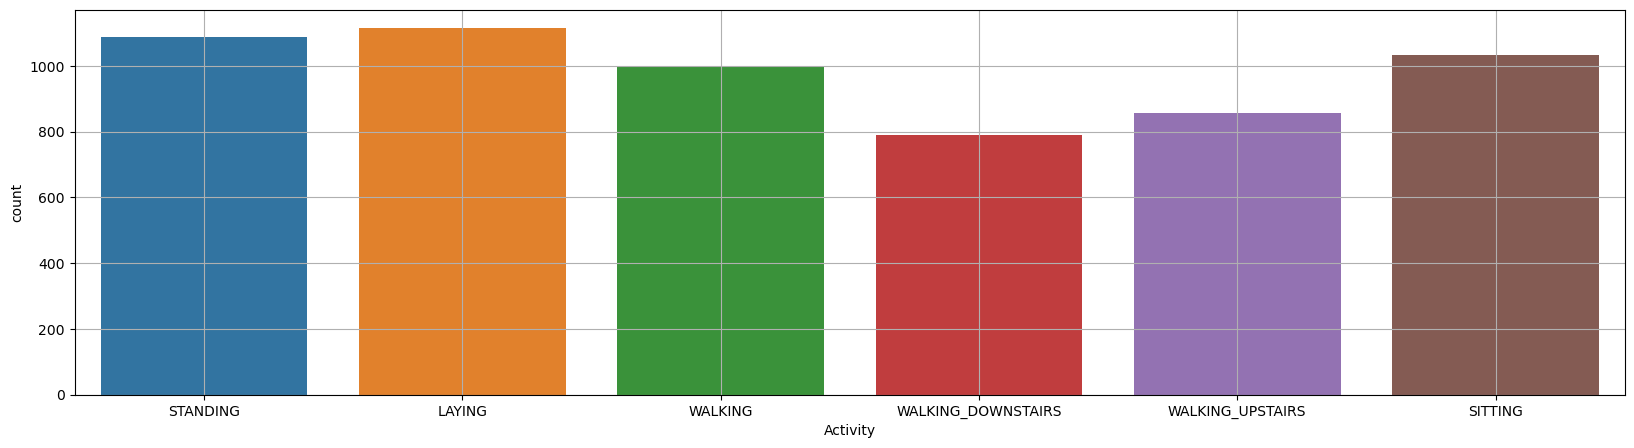

In [14]:
plt.figure(figsize=(20,5))
sns.countplot(x=target, data=data)
plt.grid()
plt.show

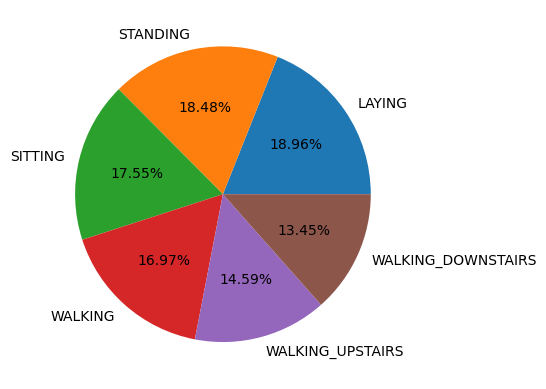

In [15]:
# 범주별 비율 구하기
temp = target.value_counts()
plt.pie(temp.values,labels=temp.index, autopct='%.2f%%')
plt.show()

### (3) 센서 그룹 데이터: features

* **세부 요구사항**
    - feature 이름에 대한 계층 구조별로 변수의 수를 카운트 해 봅시다.
        - sensor 별 변수의 개수
        - agg(regation) 별 변수의 개수
        - axis 별 변수의 개수

In [16]:
features['sensor'].value_counts()

sensor
fBodyGyro               79
fBodyAcc                79
fBodyAccJerk            79
tBodyAcc                40
tBodyAccJerk            40
tBodyGyro               40
tBodyGyroJerk           40
tGravityAcc             40
fBodyBodyGyroJerkMag    13
fBodyBodyGyroMag        13
fBodyBodyAccJerkMag     13
fBodyAccMag             13
tBodyGyroJerkMag        13
tBodyGyroMag            13
tBodyAccJerkMag         13
tGravityAccMag          13
tBodyAccMag             13
angle                    7
Name: count, dtype: int64

In [17]:
features['agg'].value_counts()

agg
bandsEnergy()        126
arCoeff()             60
mean()                33
mad()                 33
max()                 33
min()                 33
energy()              33
iqr()                 33
entropy()             33
std()                 33
sma()                 17
correlation()         15
meanFreq()            13
kurtosis()            13
skewness()            13
maxInds               13
arCoeff()3             5
arCoeff()4             5
arCoeff()2             5
arCoeff()1             5
tBodyAccMean           1
tBodyAccJerkMean       1
tBodyGyroMean          1
tBodyGyroJerkMean      1
X                      1
Y                      1
Z                      1
Name: count, dtype: int64

In [18]:
features['axis'].value_counts()

axis
X              76
Y              76
Z              76
gravityMean     6
X,2             5
               ..
25,32.1         2
17,24.1         2
1,8.1           2
9,16.1          2
gravity         1
Name: count, Length: 62, dtype: int64

## 3.데이터 분석 : 미션1

수많은 feature들을 모두 살펴보는 것은 과도한 시간과 노력이 필요합니다. 그래서 여러분은 **선택과 집중**을 해야 합니다.
* 1) **기본 모델을 생성**한 후 **변수 중요도**를 구합니다.   
    * random forest 알고리즘 사용을 권장합니다.
* 2) **중요한 feature와 중요하지 않은 feature 상위 N개를 선정**하고, 이들을 대상으로 EDA 수행.
* 3) **각 feature 그룹별 중요도**도 파악해보며 EDA를 수행  
    * Feature 이름에는 계층구조를 담고 있습니다. 그렇다 보니 feature들을 적절하게 그룹으로 묶을 수 있습니다.
    * 참고로, feature 그룹의 중요도는 개별 feature 중요도의 합으로 계산할 수 있습니다.

### (1) 기본모델링 + 변수중요도 추출

* **세부 요구사항**
    - 모델링을 위한 기본 전처리를 수행합니다.
        - 주어진 데이터에서는 x, y로 나누고 train과 validation 분할 수행
    - 트리기반 알고리즘을 이용하여 모델링을 합니다. 
        - 랜덤포레스트 권장 : 랜덤포레스트는 튜닝 없이 하이퍼파리미터의 기본값로도 적절한 성능의 모델을 생성할 수 있습니다.
    - 변수 중요도 추출
        - 사용자정의함수로 생성한 plot_feature_importance 을 이용
        - 변수중요도 파악및 결과 저장

In [19]:
target= 'Activity'
x = data.drop(target, axis=1)
y = data.loc[:,target]

In [20]:
x_train, x_val, y_train, y_val = train_test_split(x, y, train_size=0.3)

In [21]:
model = RandomForestClassifier(max_depth=10)

In [22]:
model.fit(x_train, y_train)

RandomForestClassifier(max_depth=10)

In [23]:
pred = model.predict(x_val)

,feature_name,feature_importance
0,tGravityAcc-max()-X,0.032123
1,tGravityAcc-mean()-Y,0.029594
2,tGravityAcc-min()-X,0.029098
3,tGravityAcc-energy()-X,0.028825
4,"angle(X,gravityMean)",0.026011
...,...,...
557,tBodyGyroMag-mad(),0.000070
558,tBodyGyroJerkMag-min(),0.000059
559,"fBodyGyro-bandsEnergy()-49,64.1",0.000051
560,"fBodyAcc-bandsEnergy()-57,64.1",0.000045


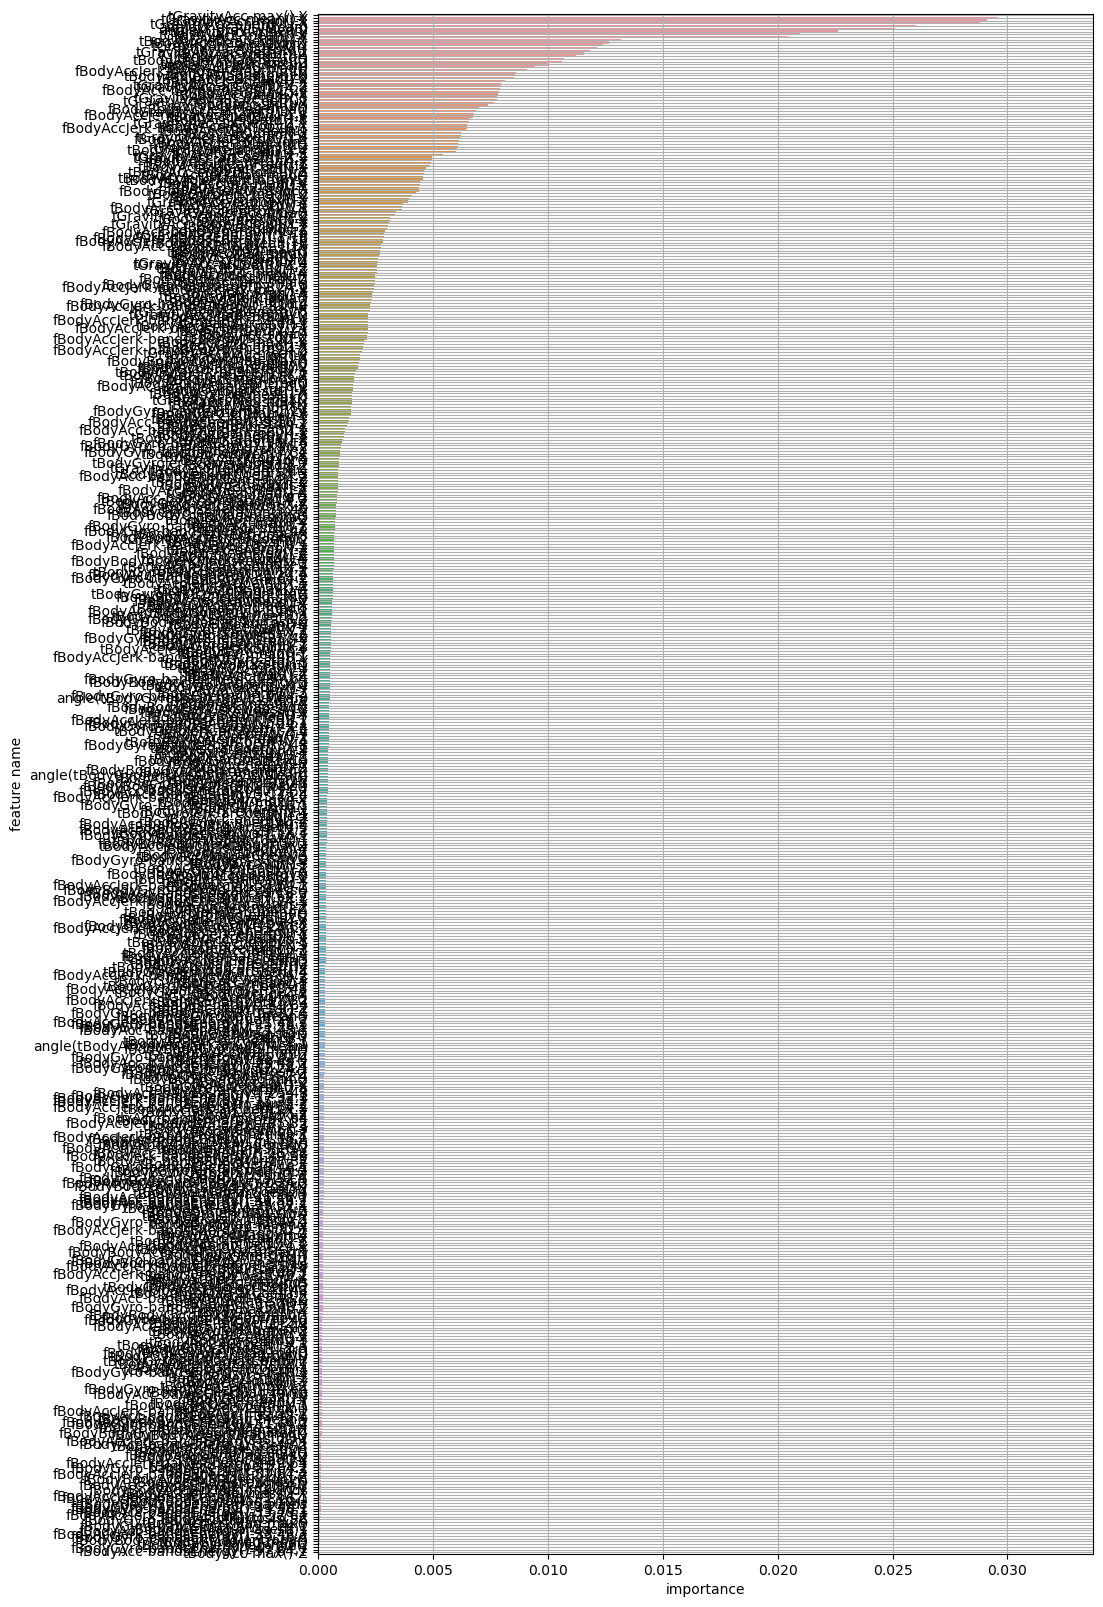

In [24]:
plot_feature_importance(importance=model.feature_importances_, names=x_val.columns)

In [25]:
importance = plot_feature_importance2(importance=model.feature_importances_, names=x_val.columns)
importance

,feature_name,feature_importance
0,tGravityAcc-max()-X,0.032123
1,tGravityAcc-mean()-Y,0.029594
2,tGravityAcc-min()-X,0.029098
3,tGravityAcc-energy()-X,0.028825
4,"angle(X,gravityMean)",0.026011
...,...,...
557,tBodyGyroMag-mad(),0.000070
558,tBodyGyroJerkMag-min(),0.000059
559,"fBodyGyro-bandsEnergy()-49,64.1",0.000051
560,"fBodyAcc-bandsEnergy()-57,64.1",0.000045


In [26]:
# 변수 중요도 상위 10개
high_importance = importance.head(5)
low_importance = importance.tail(5)
high_importance

,feature_name,feature_importance
0,tGravityAcc-max()-X,0.032123
1,tGravityAcc-mean()-Y,0.029594
2,tGravityAcc-min()-X,0.029098
3,tGravityAcc-energy()-X,0.028825
4,"angle(X,gravityMean)",0.026011


### (3) feature 그룹별 분석

* **세부 요구사항**
    - 제공된 features.csv 에는 feature에 대한 계층구조를 정리해 놓았습니다.
    - features와 변수중요도 결과를 merge 하시오.
    - sensor 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오.
    - sensor + agg 별 중요도 합계를 구하고 상위 변수 그룹별 비교 분석을 수행 하시오. 


In [27]:
feature_1 = pd.merge(features, importance)
feature_1.head()

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000489
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000308
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000196
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.004699
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000206


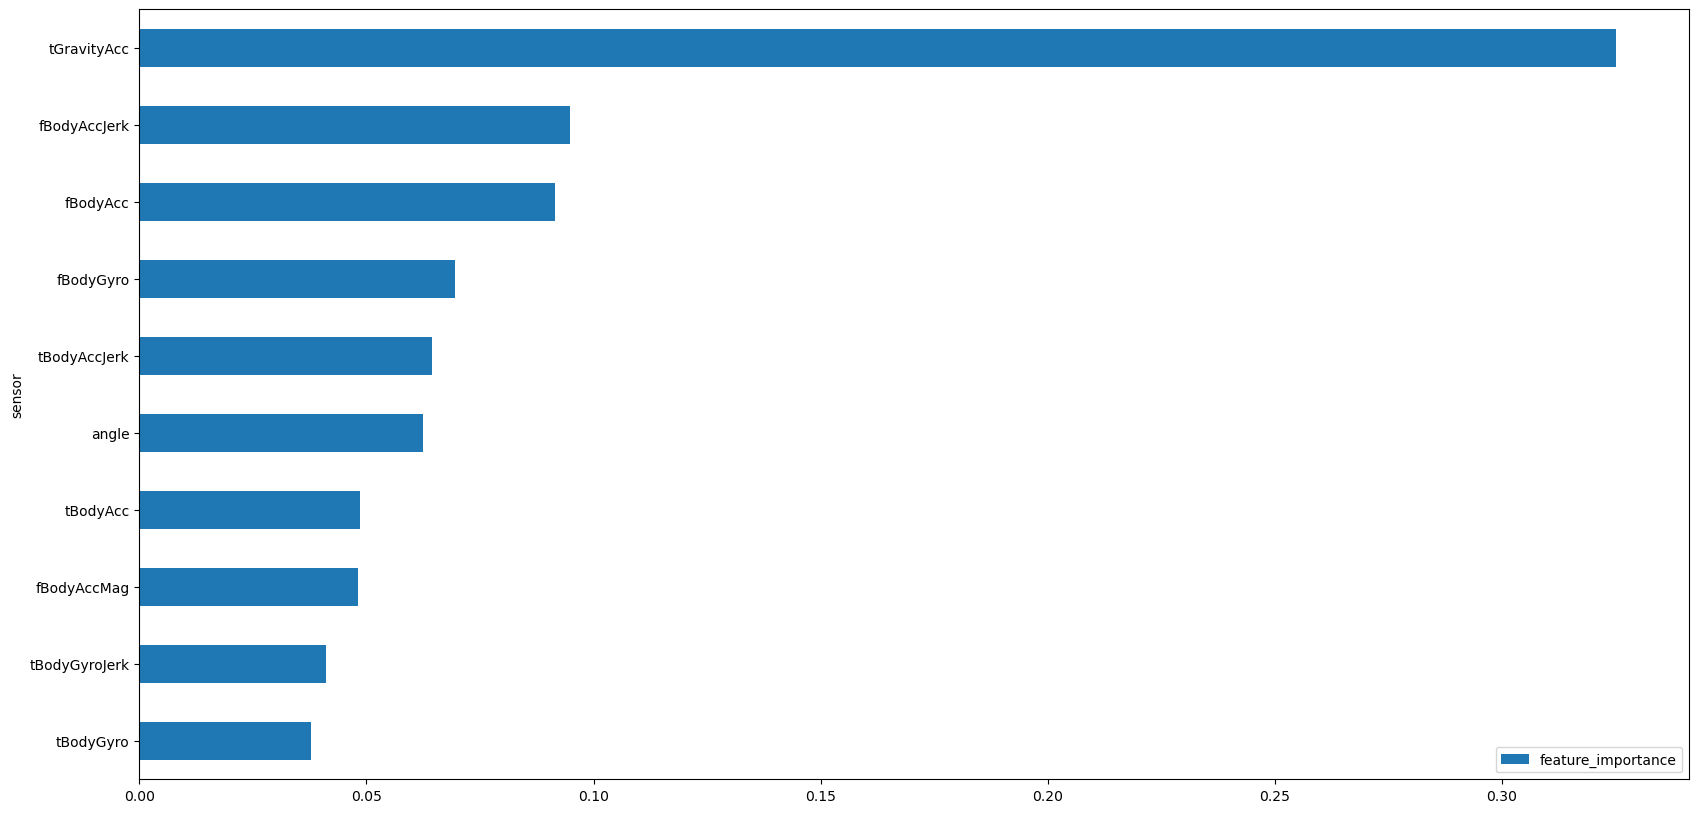

In [28]:
sensor_importance = feature_1.groupby('sensor')[['feature_importance']].sum().sort_values('feature_importance')
sensor_importance.tail(10).plot.barh(figsize=(20,10))
plt.show()

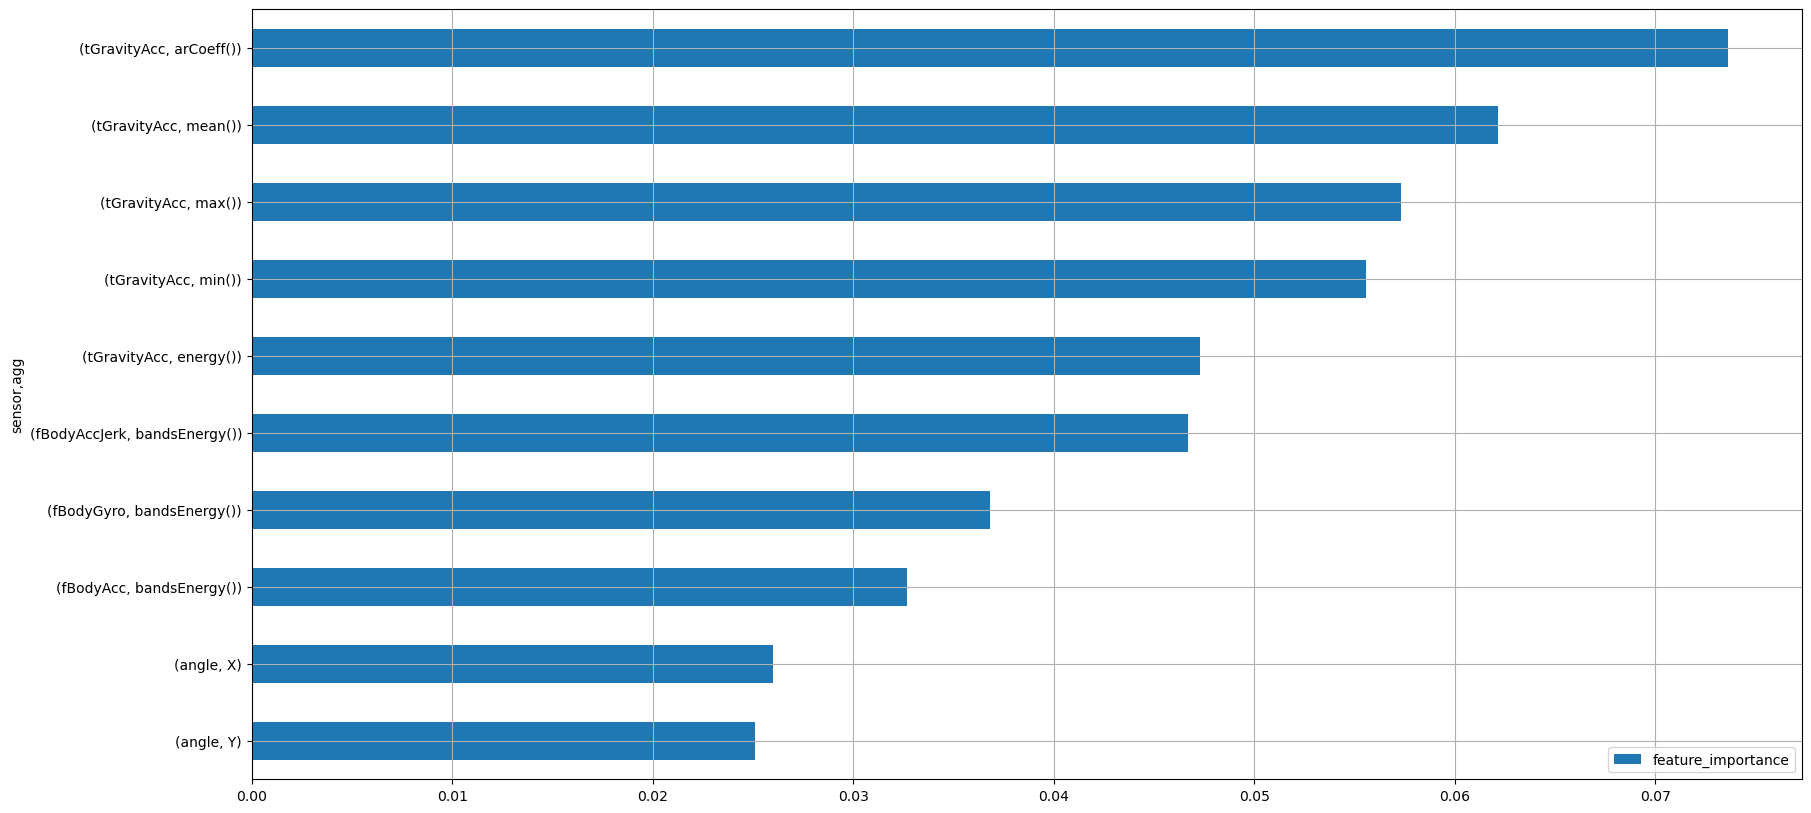

In [29]:
total_importance = feature_1.groupby(['sensor','agg'])[['feature_importance']].sum().sort_values('feature_importance')
total_importance.tail(10).plot.barh(figsize=(20,10))
plt.grid()
plt.show()

# 분석

다음의 case에 맞게 feature 및 feature 그룹 중요도를 기반으로 탐색적 데이터 분석을 수행하시오.
* 1) Target을 **정적/동적 행동**으로 구분
    * 6개의 행동은 2개의 그룹(정적행동, 동적행동)으로 나뉩니다.  
    * 어떤 feature(혹은 feature 그룹)이 2개 class 그룹(정적행동, 동적행동)를 구분하는데 중요한지를 찾아보고 탐색해봅시다. 
* 2) Target을 **개별 행동 여부**로 구분
    * 6가지의 행동을 분류하는 분석도 중요하지만, 개별 행동에만 특별히 영향을 받는 feature들도 있습니다. 
    * 예를 들어, 계단을 오르는 행동(Walking_upstairs)과 관련이 큰 feature가 있을 것입니다. [계단을 오르는 행동]인지 아닌지로 구분하는 target을 추가하여 EDA를 수행해 봅시다.

### (1) 정적/동적 행동으로 구분하여 분석하기

* **세부 요구사항**
    - Target인 Activity를 is_dynamic 변수로 변경하시오.
        * 값 0 : STANDING, SITTING, LAYING
        * 값 1 : WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS
    - is_dynamic을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_dynamic을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_dynamic 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_dynamic 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


#### 1) is_dynamic 추가

In [30]:
data_cp =data.copy()

In [31]:
def map_activity(activity):
    if activity in ['STANDING', 'SITTING', 'LAYING']:
        return 0
    elif activity in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']:
        return 1
    else:
        return 'Unknown'

# 'Activity' 열의 값을 변환하여 새로운 열에 저장
data_cp['Activity'] = data['Activity'].map(map_activity)

In [32]:
data_cp.rename(columns={'Activity': 'is_dynamic'}, inplace=True)

In [33]:
data_cp

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,1
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,1


In [34]:
target = 'is_dynamic'
x = data_cp.drop(target, axis=1)
y = data_cp.loc[:,target]

In [35]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1)

In [36]:
model_1 = RandomForestClassifier(max_depth=10)

In [37]:
model_1.fit(x_train, y_train)

RandomForestClassifier(max_depth=10)

In [38]:
pred_1 = model_1.predict(x_val)

In [39]:
importance1= plot_feature_importance2(importance=model_1.feature_importances_, names=x_val.columns)
importance1.head(20)

,feature_name,feature_importance
0,tBodyAccJerk-energy()-X,0.059990
1,fBodyAccJerk-max()-X,0.050205
2,tBodyAccJerk-mad()-X,0.040103
3,"fBodyAccJerk-bandsEnergy()-1,16",0.040049
4,"fBodyAccJerk-bandsEnergy()-1,8",0.040000
5,"fBodyAccJerk-bandsEnergy()-1,24",0.039951
6,fBodyAccJerk-mad()-X,0.039941
7,tBodyAccJerkMag-entropy(),0.029941
8,tBodyAccJerk-sma(),0.029912
9,tBodyGyroJerk-iqr()-Z,0.029882


#### 4) feature 그룹별 분석

In [40]:
feature_1 = pd.merge(features, importance1, on= 'feature_name')
feature_1

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000000
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000000
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000000
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.019868
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000000
...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000000
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000000
558,angle,X,gravityMean,"angle(X,gravityMean)",0.000000
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.000029


In [41]:
sensor_importance1 = feature_1.groupby('sensor')[['feature_importance']].sum().sort_values('feature_importance')
sensor_importance1.tail(10)

,feature_importance
sensor,
fBodyAccMag,0.009932
fBodyBodyAccJerkMag,0.019814
fBodyGyro,0.020260
tBodyGyroJerkMag,0.029766
tBodyAcc,0.029994
tBodyGyroJerk,0.079724
tBodyAccJerkMag,0.099765
fBodyAcc,0.100016
tBodyAccJerk,0.229857


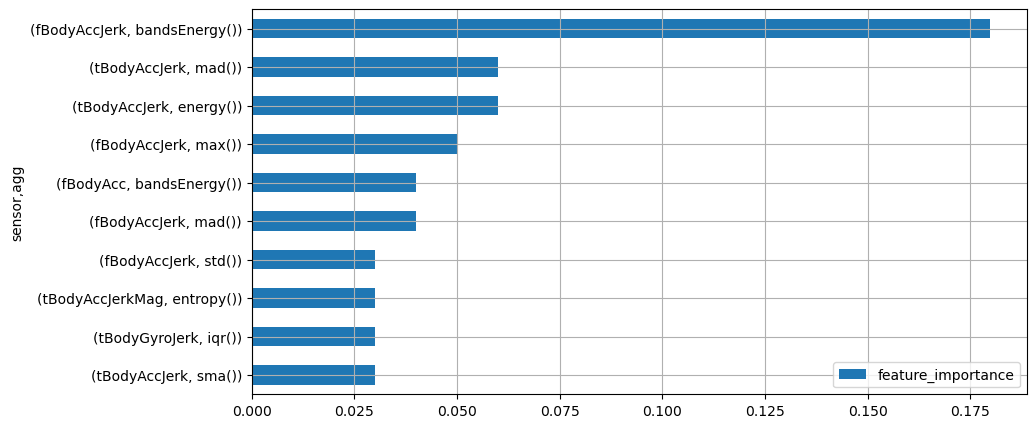

In [42]:
total_importance1 = feature_1.groupby(['sensor','agg'])[['feature_importance']].sum().sort_values('feature_importance')
total_importance1.tail(10).plot.barh(figsize=(10,5))
plt.grid()
plt.show()

### (2) 개별 동작 분석 : is_standing


* **세부 요구사항**
    - Target인 Activity를 is_standing 변수로 변경하시오.
        * 값 1 : STANDING
        * 값 0 : 나머지
    - is_standing 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_standing 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_standing 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_standing 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [43]:
data_cp2 =data.copy()

In [44]:
data_cp2['Activity'] = data_cp2['Activity'].apply(lambda x: 1 if x == 'STANDING' else 0)
data_cp2.rename(columns= {'Activity':'is_standing'},inplace=True)
data_cp2

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,is_standing
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,1
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,1
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,0


In [45]:
target = 'is_standing'
x = data_cp2.drop(target, axis=1)
y = data_cp2.loc[:,target]

In [46]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1)

In [47]:
model_2 = RandomForestClassifier(max_depth=10)
model_2.fit(x_train, y_train)

RandomForestClassifier(max_depth=10)

In [48]:
pred_2 = model_2.predict(x_val)

In [49]:
importance2= plot_feature_importance2(importance=model_2.feature_importances_, names=x_val.columns)
importance2.head(10)

,feature_name,feature_importance
0,"angle(Y,gravityMean)",0.064100
1,tGravityAcc-mean()-Y,0.052597
2,tGravityAcc-max()-Y,0.049210
3,tGravityAcc-min()-Y,0.042073
4,tGravityAcc-mean()-X,0.027974
5,tGravityAcc-energy()-Y,0.027404
6,tGravityAcc-max()-Z,0.027101
7,tGravityAcc-mean()-Z,0.026452
8,tGravityAcc-min()-Z,0.023543
9,tGravityAcc-energy()-X,0.021262


In [50]:
feature_2 = pd.merge(features, importance2, on = 'feature_name')
feature_2

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000380
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000423
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000196
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.007819
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.004198
...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000589
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.001437
558,angle,X,gravityMean,"angle(X,gravityMean)",0.017883
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.064100


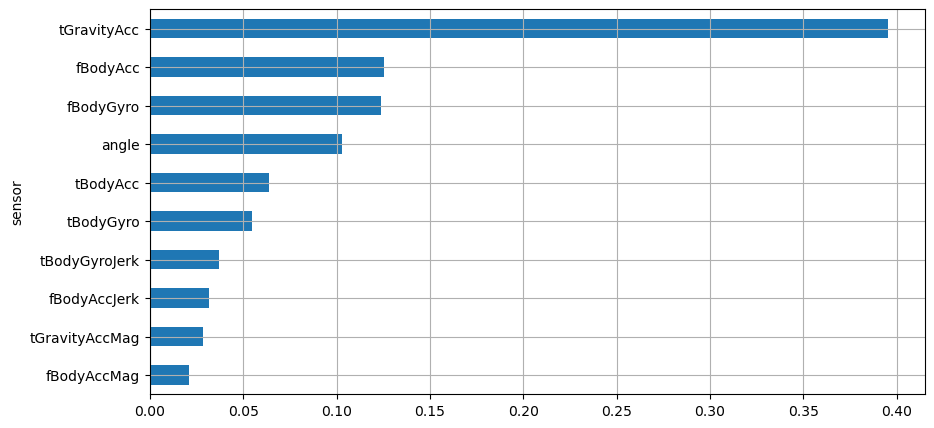

In [51]:
sensor_importance2 = feature_2.groupby('sensor')['feature_importance'].sum()
sensor_importance2.sort_values().tail(10).plot.barh(figsize=(10,5))
plt.grid()
plt.show()

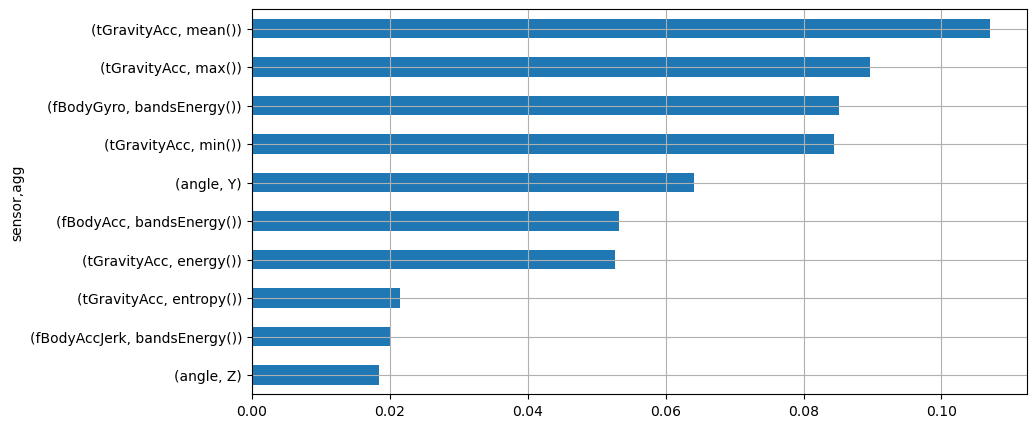

In [52]:
total_importance2 = feature_2.groupby(['sensor','agg'])['feature_importance'].sum()
total_importance2.sort_values().tail(10).plot.barh(figsize=(10,5))
plt.grid()
plt.show()

### (3) 개별 동작 분석 : is_sitting


* **세부 요구사항**
    - Target인 Activity를 is_sitting 변수로 변경하시오.
        * 값 1 : SITTING
        * 값 0 : 나머지
    - is_sitting 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_sitting 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_sitting 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_sitting 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [53]:
data_cp3=data.copy()

In [54]:
data_cp3['Activity'] = data_cp3['Activity'].apply(lambda x: 1 if x == 'SITTING' else 0)
data_cp3.rename(columns= {'Activity':'is_sitting'},inplace=True)
data_cp3

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,is_sitting
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,1
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,0


In [55]:
target = 'is_sitting'
x = data_cp3.drop(target, axis=1)
y = data_cp3.loc[:,target]

In [56]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1)

In [57]:
model_3 = RandomForestClassifier(max_depth=10)
model_3.fit(x_train, y_train)

RandomForestClassifier(max_depth=10)

In [58]:
pred_3 = model_3.predict(x_val)
importance3= plot_feature_importance2(importance=model_3.feature_importances_, names=x_val.columns)
importance3.head(10)

,feature_name,feature_importance
0,tGravityAcc-max()-Y,0.056933
1,tGravityAcc-mean()-Y,0.046331
2,"angle(Y,gravityMean)",0.041148
3,tGravityAcc-min()-Y,0.039431
4,"angle(X,gravityMean)",0.035354
5,tGravityAcc-mean()-X,0.030551
6,tGravityAcc-max()-X,0.024577
7,tGravityAcc-energy()-Y,0.022189
8,tGravityAcc-max()-Z,0.020347
9,tGravityAcc-min()-X,0.019699


In [59]:
feature_3 = pd.merge(features, importance3, on = 'feature_name')
feature_3.tail(10)

,sensor,agg,axis,feature_name,feature_importance
551,fBodyBodyGyroJerkMag,meanFreq(),NaN,fBodyBodyGyroJerkMag-meanFreq(),0.000234
552,fBodyBodyGyroJerkMag,skewness(),NaN,fBodyBodyGyroJerkMag-skewness(),0.000130
553,fBodyBodyGyroJerkMag,kurtosis(),NaN,fBodyBodyGyroJerkMag-kurtosis(),0.000282
554,angle,tBodyAccMean,gravity,"angle(tBodyAccMean,gravity)",0.000262
555,angle,tBodyAccJerkMean,gravityMean,"angle(tBodyAccJerkMean),gravityMean)",0.000160
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.001287
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.001051
558,angle,X,gravityMean,"angle(X,gravityMean)",0.035354
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.041148
560,angle,Z,gravityMean,"angle(Z,gravityMean)",0.014495


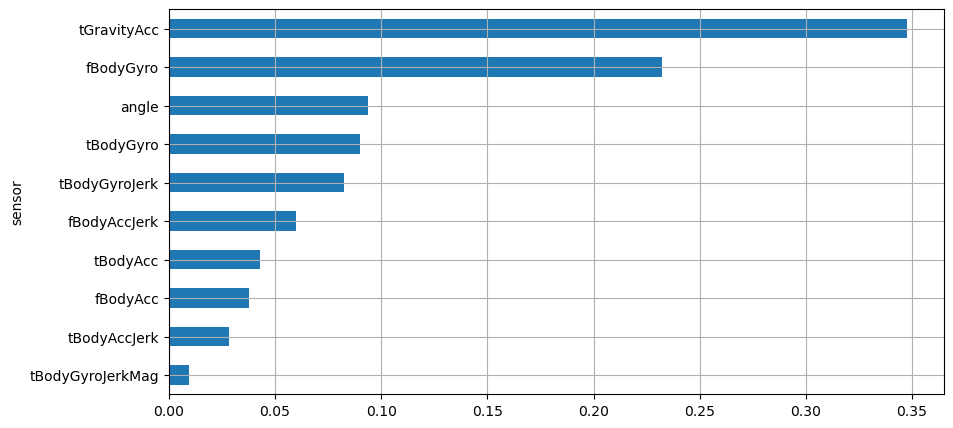

In [60]:
sensor_importance3 = feature_3.groupby('sensor')['feature_importance'].sum().sort_values()
sensor_importance3.tail(10).plot.barh(figsize=(10,5))
plt.grid()
plt.show()

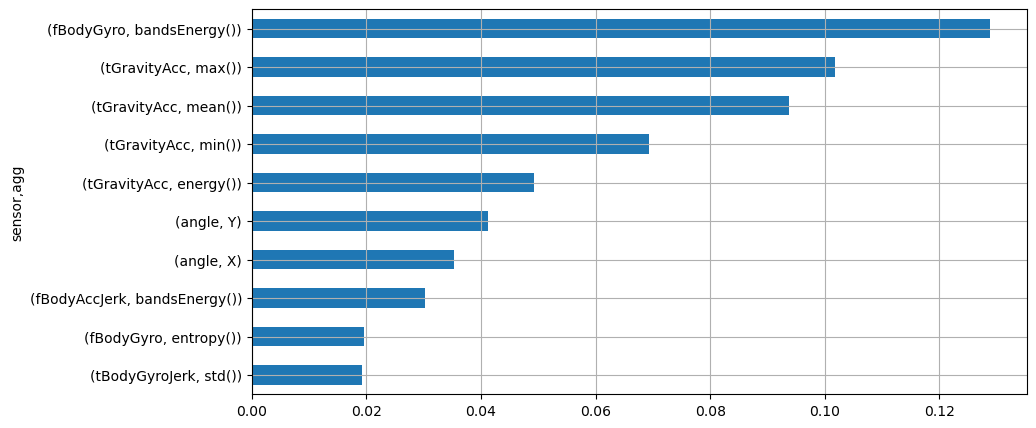

In [61]:
total_importance3 = feature_3.groupby(['sensor','agg'])['feature_importance'].sum().sort_values()
total_importance3.tail(10).plot.barh(figsize=(10,5))
plt.grid()
plt.show()

### (4) 개별 동작 분석 : is_laying


* **세부 요구사항**
    - Target인 Activity를 is_laying 변수로 변경하시오.
        * 값 1 : LAYING
        * 값 0 : 나머지
    - is_laying 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_laying 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_laying 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_laying 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [62]:
data_cp4 = data.copy()
data_cp4['Activity'] = data_cp4['Activity'].apply(lambda x: 1 if x == 'LAYING' else 0)
data_cp4.rename(columns={'Activity':'is_laying'}, inplace= True)
data_cp4

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,is_laying
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,1
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,1
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,0


In [63]:
target = 'is_laying'
x = data_cp4.drop(target, axis =1)
y = data_cp4.loc[:,target]

In [64]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1)

In [65]:
model_4 = RandomForestClassifier(max_depth=10)
model_4.fit(x_train, y_train)

RandomForestClassifier(max_depth=10)

In [66]:
pred_4 = model_4.predict(x_val)

In [67]:
importance4 =plot_feature_importance2(importance=model_4.feature_importances_, names=x_val.columns)
importance4.head(10)

,feature_name,feature_importance
0,tGravityAcc-energy()-X,0.128754
1,tGravityAcc-mean()-X,0.100578
2,tGravityAcc-min()-X,0.074516
3,"angle(X,gravityMean)",0.070788
4,tGravityAcc-max()-X,0.066629
5,tGravityAcc-energy()-Y,0.065781
6,tGravityAcc-min()-Y,0.056573
7,tGravityAcc-max()-Z,0.051334
8,tGravityAcc-mean()-Z,0.036969
9,"angle(Y,gravityMean)",0.036542


In [68]:
feature_4 = pd.merge(features, importance4, on='feature_name')
feature_4.tail(10)

,sensor,agg,axis,feature_name,feature_importance
551,fBodyBodyGyroJerkMag,meanFreq(),NaN,fBodyBodyGyroJerkMag-meanFreq(),0.000117
552,fBodyBodyGyroJerkMag,skewness(),NaN,fBodyBodyGyroJerkMag-skewness(),0.000052
553,fBodyBodyGyroJerkMag,kurtosis(),NaN,fBodyBodyGyroJerkMag-kurtosis(),0.000000
554,angle,tBodyAccMean,gravity,"angle(tBodyAccMean,gravity)",0.000079
555,angle,tBodyAccJerkMean,gravityMean,"angle(tBodyAccJerkMean),gravityMean)",0.000000
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000037
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000024
558,angle,X,gravityMean,"angle(X,gravityMean)",0.070788
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.036542
560,angle,Z,gravityMean,"angle(Z,gravityMean)",0.021996


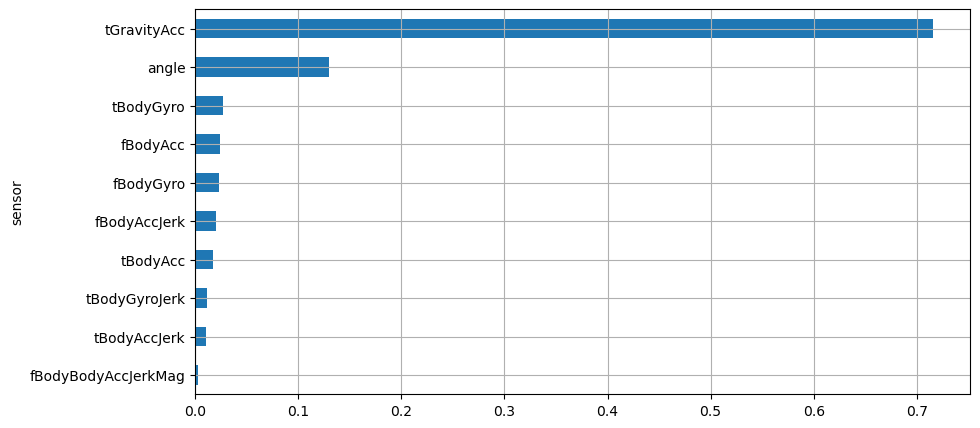

In [69]:
sensor_importance4 = feature_4.groupby('sensor')['feature_importance'].sum().sort_values()
sensor_importance4.tail(10).plot.barh(figsize=(10,5))
plt.grid()
plt.show()

### (5) 개별 동작 분석 : is_walking


* **세부 요구사항**
    - Target인 Activity를 is_walking 변수로 변경하시오.
        * 값 1 : WALKING
        * 값 0 : 나머지
    - is_walking 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [70]:
data_cp5 =data.copy()

In [71]:
data_cp5['Activity'] = data_cp5['Activity'].apply(lambda x: 1 if x == 'WALKING' else 0)
data_cp5.rename(columns={'Activity':'is_walking'}, inplace=True)
data_cp5

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,is_walking
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,0


In [72]:
target = 'is_walking'
x = data_cp5.drop(target, axis=1)
y = data_cp5.loc[:,target]

In [73]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1)

In [74]:
model_5 = RandomForestClassifier(max_depth=10)
model_5.fit(x_train, y_train)

RandomForestClassifier(max_depth=10)

In [75]:
pred_5 = model_5.predict(x_val)

In [76]:
importance5= plot_feature_importance2(importance=model_5.feature_importances_,names=x_val.columns)
importance5.head(10)

,feature_name,feature_importance
0,fBodyAccMag-std(),0.039047
1,"tBodyAcc-correlation()-X,Y",0.027598
2,fBodyAccJerk-max()-Y,0.020292
3,tBodyGyroJerk-mad()-X,0.018162
4,tBodyAccMag-mad(),0.017845
5,tGravityAccMag-arCoeff()1,0.017157
6,fBodyAccMag-max(),0.016663
7,fBodyAccJerk-std()-Y,0.016454
8,tBodyGyroJerk-std()-X,0.015854
9,tBodyAccJerk-energy()-Y,0.015811


In [77]:
feature_5 = pd.merge(features, importance5, on='feature_name')
feature_5

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000116
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000137
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000018
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.009719
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000120
...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000277
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000342
558,angle,X,gravityMean,"angle(X,gravityMean)",0.001198
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.004136


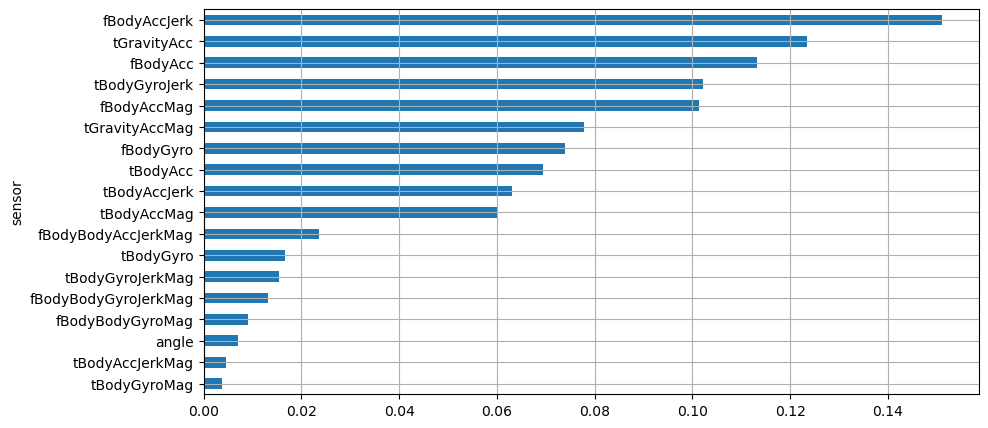

In [78]:
sensor_importance5 = feature_5.groupby('sensor')['feature_importance'].sum()
sensor_importance5.sort_values().tail(20).plot.barh(figsize=(10,5))
plt.grid()
plt.show()

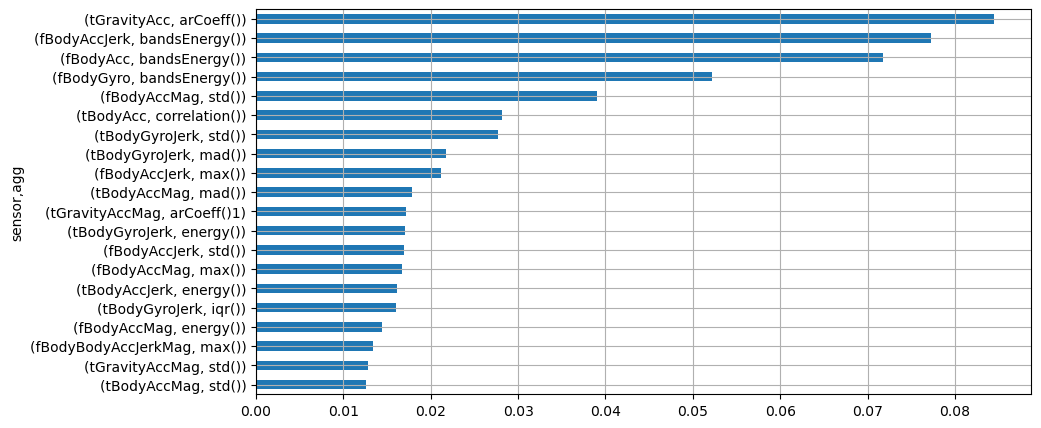

In [79]:
total_importance5 = feature_5.groupby(['sensor','agg'])['feature_importance'].sum()
total_importance5.sort_values().tail(20).plot.barh(figsize=(10,5))
plt.grid()
plt.show()

### (6) 개별 동작 분석 : is_walking_up


* **세부 요구사항**
    - Target인 Activity를 is_walking_up 변수로 변경하시오.
        * 값 1 : WALKING_UPSTAIRS
        * 값 0 : 나머지
    - is_walking_up 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_up 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_up 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_up 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [80]:
data_cp6 = data.copy()
data_cp6

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,SITTING
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,WALKING_UPSTAIRS
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,LAYING
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,WALKING_UPSTAIRS


In [81]:
data_cp6['Activity'] = data_cp6['Activity'].apply(lambda x: 1 if x == 'WALKING_UPSTAIRS' else 0)
data_cp6.rename(columns={'Activity':'is_walking_up'}, inplace=True)
data_cp6

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,is_walking_up
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,1
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,1


In [82]:
target = 'is_walking_up'
x = data_cp6.drop(target, axis=1)
y = data_cp6.loc[:,target]

In [83]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1)

In [84]:
model_6 = RandomForestClassifier(max_depth=10)
model_6.fit(x_train, y_train)

RandomForestClassifier(max_depth=10)

In [85]:
pred_6 = model_6.predict(x_val)

In [86]:
importance6=plot_feature_importance2(importance=model_6.feature_importances_ , names=x_val.columns)
importance6.head(10)

,feature_name,feature_importance
0,tGravityAcc-min()-Y,0.032756
1,"tGravityAcc-arCoeff()-Z,3",0.030445
2,tGravityAcc-mean()-Y,0.025123
3,"angle(Y,gravityMean)",0.024030
4,"tGravityAcc-arCoeff()-Z,4",0.022563
5,"tGravityAcc-arCoeff()-Y,2",0.022353
6,"tGravityAcc-arCoeff()-Y,1",0.021975
7,"tGravityAcc-arCoeff()-Z,1",0.021896
8,tGravityAcc-energy()-Y,0.017700
9,fBodyAcc-meanFreq()-Z,0.016603


In [87]:
feature_6 = pd.merge(features, importance6, on='feature_name')
feature_6.head()

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000088
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000849
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000248
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.003505
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000370


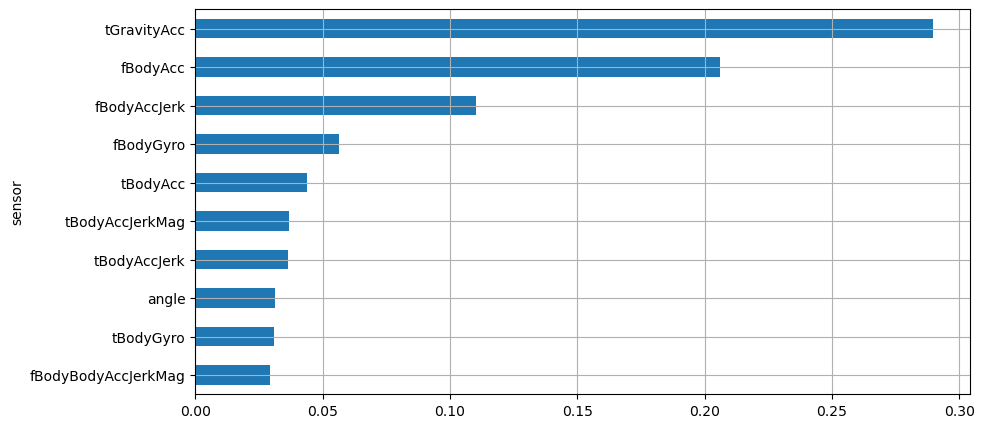

In [88]:
sensor_importance6 = feature_6.groupby('sensor')['feature_importance'].sum()
sensor_importance6.sort_values().tail(10).plot.barh(figsize=(10,5))
plt.grid()
plt.show()

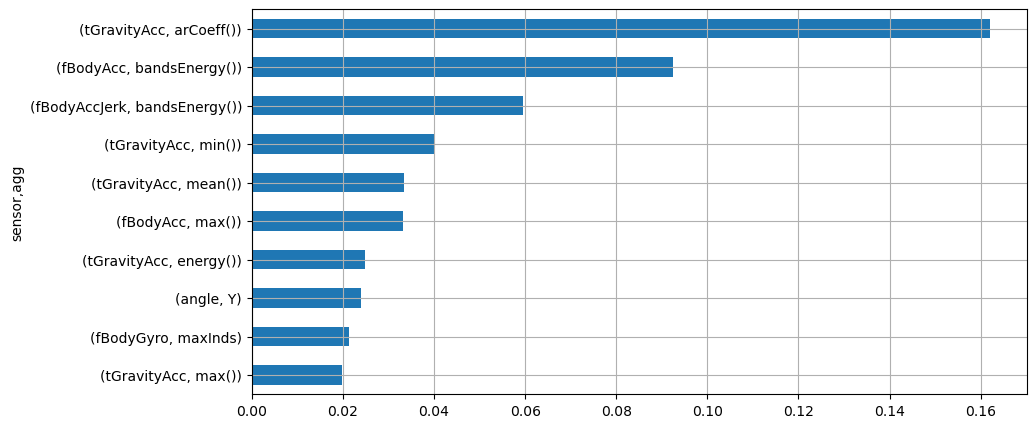

In [89]:
total_importance6 = feature_6.groupby(['sensor','agg'])['feature_importance'].sum()
total_importance6.sort_values().tail(10).plot.barh(figsize=(10,5))
plt.grid()
plt.show()

### (7) 개별 동작 분석 : is_walking_down


* **세부 요구사항**
    - Target인 Activity를 is_walking_down 변수로 변경하시오.
        * 값 1 : WALKING_DOWNSTAIRS
        * 값 0 : 나머지
    - is_walking_down 을 예측하기 위한 기본 모델을 생성하시오.
        * x, is_walking_down 을 이용하여 train과 validation으로 데이터 분할
        * 기본 모델링
    - is_walking_down 을 구분하는데 중요한 변수 상위 5를 분석하시오.
    - is_walking_down 을 구분하는데 중요한 변수 그룹을 분석하시오.
        * sensor별
        * sensor+agg 별


In [90]:
data_cp7 = data.copy()

In [91]:
data_cp7['Activity'] = data_cp7['Activity'].apply(lambda x: 1 if x == 'WALKING_DOWNSTAIRS' else 0)
data_cp7.rename(columns={'Activity':'is_walking_down'}, inplace=True)
data_cp7

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,is_walking_down
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,21,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,15,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,11,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,17,0
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5876,0.277194,-0.012389,-0.131974,-0.994046,-0.940578,-0.917337,-0.994261,-0.932830,-0.908088,-0.936219,...,-0.690363,-0.034888,-0.261437,-0.391477,-0.877612,-0.912365,0.114009,0.080146,21,0
5877,0.191568,0.013328,-0.105174,-0.126969,-0.121729,-0.327480,-0.192523,-0.109923,-0.295286,0.078644,...,-0.879215,0.721718,0.623151,0.866858,-0.445660,-0.690278,0.303194,-0.044188,15,0
5878,0.267981,-0.018348,-0.107440,-0.991303,-0.989881,-0.990313,-0.992386,-0.988852,-0.991237,-0.936099,...,-0.886851,0.060173,0.228739,0.684400,-0.216665,0.620363,-0.437247,-0.571840,19,0
5879,0.212787,-0.048130,-0.121001,-0.041373,0.052449,-0.585361,-0.100714,0.023353,-0.554707,0.219814,...,-0.053556,0.260880,0.551742,-0.943773,-0.862899,-0.718009,0.292856,0.024920,6,0


In [92]:
target = 'is_walking_down'
x = data_cp7.drop(target, axis=1)
y = data_cp7.loc[:,target]

In [93]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1)

In [94]:
model_7 = RandomForestClassifier(max_depth=10)
model_7.fit(x_train, y_train)

RandomForestClassifier(max_depth=10)

In [95]:
pred_7 = model_7.predict(x_val)
importance7= plot_feature_importance2(importance=model_7.feature_importances_, names = x_val.columns)
importance7.head(10)

,feature_name,feature_importance
0,fBodyAccMag-energy(),0.078246
1,fBodyAccMag-mean(),0.042525
2,tGravityAccMag-mad(),0.035780
3,fBodyAccMag-mad(),0.035568
4,tBodyAccMag-std(),0.034525
5,tBodyAcc-max()-X,0.030533
6,fBodyAcc-mad()-X,0.029749
7,tGravityAccMag-std(),0.029360
8,fBodyAcc-energy()-X,0.026145
9,fBodyAcc-mean()-X,0.025735


In [96]:
feature_7 = pd.merge(features, importance7)
feature_7.head(10)

,sensor,agg,axis,feature_name,feature_importance
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000329
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000247
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000458
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.019025
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000618
5,tBodyAcc,std(),Z,tBodyAcc-std()-Z,0.000527
6,tBodyAcc,mad(),X,tBodyAcc-mad()-X,0.017174
7,tBodyAcc,mad(),Y,tBodyAcc-mad()-Y,0.001521
8,tBodyAcc,mad(),Z,tBodyAcc-mad()-Z,0.000702
9,tBodyAcc,max(),X,tBodyAcc-max()-X,0.030533


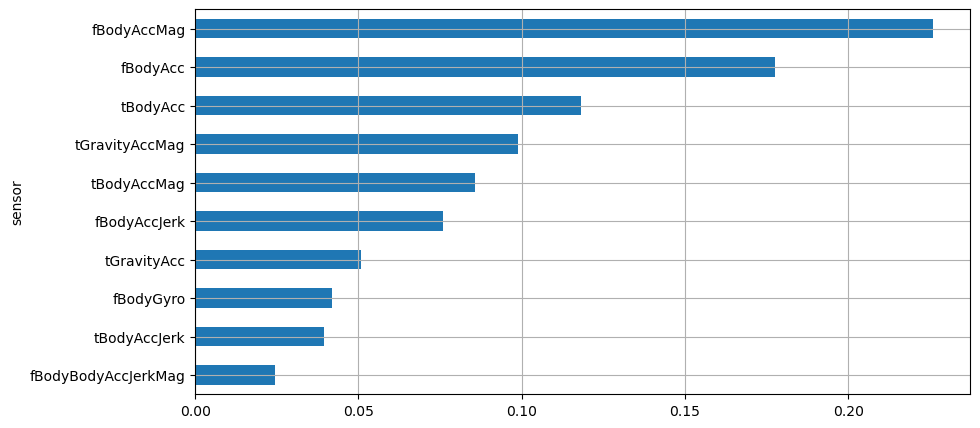

In [97]:
sensor_importance7 = feature_7.groupby('sensor')['feature_importance'].sum()
sensor_importance7.sort_values().tail(10).plot.barh(figsize=(10,5))
plt.grid()
plt.show()

## 5.특성 중요도 저장하기

* **세부 요구사항**
    - 지금까지 변수 중요도를 다양한 관점에서 뽑고 분석을 해 보았습니다.
        - 관점1 : 6개 행동 구분
        - 관점2 : 동적, 정적 행동 구분
        - 관점3 : Standing 여부 구분
        - 관점4 : Sitting 여부 구분
        - 관점5 : Laying 여부 구분
        - 관점6 : Walking 여부 구분
        - 관점7 : Walking_upstairs 여부 구분
        - 관점8 : Walking_downstairs 여부 구분
    - 모든 관점의 변수 중요도를 하나로 합친 후 저장
        - merge를 이용하여 features와 합칩니다.
        - joblib 패키지의 dump를 이용하여 결과를 저장합니다.

### (1) 하나로 합치기
* 합치기 위해서는 중요도 결과에서 feature_importance 칼럼 이름을 수정해야 합니다.
* pd.merge를 이용해서 하나씩 합치는 작업을 반복 합니다|

In [98]:
importance.rename(columns={'feature_importance':'behavior'},inplace=True)
feature = pd.merge(features,importance, on='feature_name')
importance1.rename(columns={'feature_importance':'moving'},inplace=True)
feature = pd.merge(feature, importance1, on='feature_name')
feature.head()

,sensor,agg,axis,feature_name,behavior,moving
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000489,0.000000
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000308,0.000000
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000196,0.000000
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.004699,0.019868
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000206,0.000000


In [99]:
importance2.rename(columns={'feature_importance':'standing'}, inplace=True)
feature = pd.merge(feature, importance2, on='feature_name')
importance3.rename(columns={'feature_importance':'sitting'}, inplace=True)
feature = pd.merge(feature, importance3, on='feature_name')
importance4.rename(columns={'feature_importance':'laying'}, inplace=True)
feature = pd.merge(feature, importance4, on='feature_name')
importance5.rename(columns={'feature_importance':'walking'}, inplace=True)
feature = pd.merge(feature, importance5, on='feature_name')
importance6.rename(columns={'feature_importance':'upstairs'}, inplace=True)
feature = pd.merge(feature, importance6, on='feature_name')
importance7.rename(columns={'feature_importance':'downstairs'}, inplace=True)
feature = pd.merge(feature, importance7, on='feature_name')
feature

,sensor,agg,axis,feature_name,behavior,moving,standing,sitting,laying,walking,upstairs,downstairs
0,tBodyAcc,mean(),X,tBodyAcc-mean()-X,0.000489,0.000000,0.000380,0.000324,0.000037,0.000116,0.000088,0.000329
1,tBodyAcc,mean(),Y,tBodyAcc-mean()-Y,0.000308,0.000000,0.000423,0.000460,0.000229,0.000137,0.000849,0.000247
2,tBodyAcc,mean(),Z,tBodyAcc-mean()-Z,0.000196,0.000000,0.000196,0.000316,0.000083,0.000018,0.000248,0.000458
3,tBodyAcc,std(),X,tBodyAcc-std()-X,0.004699,0.019868,0.007819,0.002276,0.000000,0.009719,0.003505,0.019025
4,tBodyAcc,std(),Y,tBodyAcc-std()-Y,0.000206,0.000000,0.004198,0.000519,0.000000,0.000120,0.000370,0.000618
...,...,...,...,...,...,...,...,...,...,...,...,...
556,angle,tBodyGyroMean,gravityMean,"angle(tBodyGyroMean,gravityMean)",0.000499,0.000000,0.000589,0.001287,0.000037,0.000277,0.000540,0.000567
557,angle,tBodyGyroJerkMean,gravityMean,"angle(tBodyGyroJerkMean,gravityMean)",0.000426,0.000000,0.001437,0.001051,0.000024,0.000342,0.000207,0.000195
558,angle,X,gravityMean,"angle(X,gravityMean)",0.026011,0.000000,0.017883,0.035354,0.070788,0.001198,0.004208,0.001796
559,angle,Y,gravityMean,"angle(Y,gravityMean)",0.025085,0.000029,0.064100,0.041148,0.036542,0.004136,0.024030,0.002663


In [100]:
dump(feature,'save_feature')

['save_feature']